In [2]:
cd ..

/work


# Lecture dataset

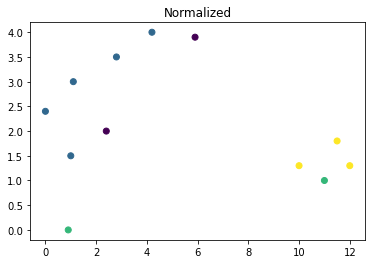

In [3]:
import pandas as pd
from src.datasets import Dataset
from src.utils import *

dataset = Dataset('./data/lecture_dataset.txt') 
X, y = dataset.X, dataset.y
df = pd.read_csv("./out/dbscanrn_opt_cpp_lecture_dataset.csv", header=None)
y_pred, state = df[0], df[1]
display_points(X, y_pred, 'Normalized', numerate=False)

# OUT

In [24]:
pd.options.display.max_rows = None

logs = pd.read_csv(
    'out/LOG_dbscanrn_opt_cpp_compound_dataset_D2_R399_k25_cosine_dissimilarity_r01.log',
    names=['time [ms]', 'operation', 'point_id', 'value', 'string'],
    index_col=False
)
logs['time [ms]'] -= logs['time [ms]'].min()
logs.head()

,time [ms],operation,point_id,value,string
0,0.000000,reading_data,NaN,0.019828,NaN
1,11.161361,start log,NaN,NaN,NaN
2,11.164380,normalization_time,NaN,0.002239,NaN
3,11.166645,pessimistic_estimation_time,0.0,0.001391,NaN
4,11.167293,dist_to_ref_point_time,0.0,0.000085,NaN


In [25]:
logs['operation'].unique()

array(['reading_data', 'start log', 'normalization_time',
       'pessimistic_estimation_time', 'dist_to_ref_point_time',
       'sorting_pessimistic_est_time', 'knn_neighbors_id',
       '|knn_neighbors|', 'similarity_calculation', 'knn_time',
       'rnn_neighbors_id', '|rnn_neighbors|', 'rnn_time', 'stop log',
       'writing_data'], dtype=object)

In [26]:
logs[logs['operation'] == 'similarity_calculation']

,time [ms],operation,point_id,value,string
31,11.194239,similarity_calculation,5.0,1.0,NaN
37,11.199836,similarity_calculation,6.0,1.0,NaN


In [ ]:
name = "dbscanrn_opt_cpp_compound_dataset_D2_R399_k25_cosine_dissimilarity_r01"

In [ ]:
import time 
import numpy as np

timer_start = time.time()
# logs = algorithm.get_logs()
mask = logs['operation'] == 'similarity_calculation'
similarity_calculation = logs[mask].groupby('point_id').sum().reset_index().drop(columns=['time [ms]'])
similarity_calculation.rename(columns={'value': '# of distance/similarity calculations'}, inplace=True)

out = pd.DataFrame({
    'point_id': np.arange(dataset.n_rows),
    'x': dataset.X[:, 0], 
    'y': dataset.X[:, 1],
    'point_type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(similarity_calculation, on='point_id')
out.to_csv(f'./out/OUT_{name}.csv', index=False)
saving_OUT_time = (time.time() - timer_start) * 1000
out.head()

,point_id,x,y,point_type,CId,# of distance/similarity calculations


# STAT

In [ ]:
params = {
    'k': 25,
    'similarity': 'cosine_dissimilarity'
}

normalization_runtime = 0
total_runtime = 0

In [ ]:
from src.clusterization_performance import *

score = evaluate(y_pred, dataset.y, dataset.X)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': dataset.n_dimentions,
    '# of points in the input file': dataset.n_rows,
    'epsilon': params['epsilon'] if 'epsilon' in params else '',
    'minPts': params['minPts'] if 'minPts' in params else '',
    'k':  params['k'] if 'k' in params else '',
    'similarity': params['similarity'],
    'values of dimensions of a reference point': '[0,1]',
    'reading the input file [ms]': logs.loc[logs['operation'] == 'reading_data', 'value'].values[0] * 1000,
    'normalization of vectors [ms]': logs.loc[logs['operation'] == 'normalization_time', 'value'].values[0] * 1000,
    "Eps-neighborhood timer [ms]": logs.loc[logs['operation'] == 'Eps_time', 'value'].sum() * 1000,
    'Clustering timer [ms]': (
        logs.loc[logs['operation'] == 'stop log', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'start log', 'time [ms]'].values[0]
    ) * 1000,
    'saving results to OUT time [ms]': logs.loc[logs['operation'] == 'writing_data', 'value'].values[0] * 1000,
    "dist_to_ref_point_time [ms]": logs[logs['operation'] == 'dist_to_ref_point_time']['value'].sum() * 1000,
    'total runtime [ms]': (
        logs.loc[logs['operation'] == 'writing_data', 'time [ms]'].values[0] - 
        logs.loc[logs['operation'] == 'reading_data', 'time [ms]'].values[0]
    ) * 1000,
    "sorting_dist_time [ms]": logs[logs['operation'] == 'sorting_pessimistic_est_time']['value'].sum() * 1000,
    "tiknn_time [ms]": logs[logs['operation'] == 'tiknn_time']['value'].sum() * 1000,
    "tirnn_time [ms]": logs[logs['operation'] == 'tirnn_time']['value'].sum() * 1000,
    '# of discovered clusters': sum(out['CId'] > -1),
    '# of discovered noise points': sum(out['point_type'] == -1),
    '# of discovered core points': sum(out['point_type'] == 1),
    '# of discovered border points': sum(out['point_type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    # '|TP|': score['TP'],
    # '|TN|': score['TN'],
    # '# of pairs of points': len(algorithm.y_pred),
    # 'RAND': score['rand_score'],
    # 'Purity': score['purity'],
    # 'Silhouette coefficient': score['silhouette_score_euclidean'],
    # 'Davies Bouldin': score['davies_bouldin_score']
}, index=['values']).T
stat_time = time.time() - timer_stat
print(stat_time)
stat.to_csv(f'./out/STAT_{name}.csv', index=False)
stat

KeyError: '# of distance/similarity calculations'

# DEBUG

# Compound dbscanrn_opt

In [ ]:
mask1 = logs['operation'] == '|knn_neighbors|'
mask2 = logs['operation'] == 'knn_neighbors_id'
mask3 = logs['operation'] == '|rnn_neighbors|'
mask4 = logs['operation'] == 'rnn_neighbors_id'

debug1 = (
    logs[mask1]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug1.reset_index(col_level=1, inplace=True)
debug1.columns.name = None

debug2 = (
    logs[mask2]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug2.reset_index(col_level=1, inplace=True)
debug2.columns.name = None

debug3 = (
    logs[mask3]
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'value', 
    )
)
debug3.reset_index(col_level=1, inplace=True)
debug3.columns.name = None

debug4 = (
    logs[mask4]
    .fillna('')
    .pivot_table(
        index=['point_id'], 
        columns=['operation'], 
        values= 'string', 
        aggfunc=lambda x: ' '.join(x)
))   
debug4.reset_index(col_level=1, inplace=True)
debug4.columns.name = None


debug = debug1.merge(debug2, on='point_id').merge(debug3, on='point_id').merge(debug4, on='point_id')
debug.to_csv(f'./out/DEBUG_{name}.csv', index=False)
debug

,point_id,|knn_neighbors|,knn_neighbors_id,|rnn_neighbors|,rnn_neighbors_id
0,0.0,25.0,215;243;231;272;273;265;232;268;235;234;244;22...,25.0,215;243;231;272;273;265;232;268;235;234;244;22...
1,1.0,25.0,321;223;275;322;266;280;3;279;315;318;316;319;...,25.0,321;223;275;322;266;280;3;279;315;318;316;319;...
2,2.0,25.0,325;4;329;330;334;282;47;281;326;278;324;333;3...,25.0,325;4;329;330;334;282;47;281;326;278;324;333;3...
3,3.0,25.0,280;266;279;275;223;316;1;321;319;222;246;322;...,25.0,280;266;279;275;223;316;1;321;319;222;246;322;...
4,4.0,25.0,2;325;330;329;334;282;47;281;326;333;395;278;3...,25.0,2;325;330;329;334;282;47;281;326;333;395;278;3...
5,5.0,25.0,327;323;317;276;277;328;318;315;324;278;326;28...,25.0,327;323;317;276;277;328;318;315;324;278;326;28...
6,6.0,25.0,331;395;333;332;47;48;398;46;286;282;284;285;3...,25.0,331;395;333;332;47;48;398;46;286;282;284;285;3...
7,7.0,25.0,50;49;52;386;392;388;51;55;339;289;43;397;53;5...,25.0,50;49;52;386;392;388;51;55;339;289;43;397;53;5...
8,8.0,25.0,387;335;283;336;396;337;393;394;397;285;284;28...,25.0,387;335;283;336;396;337;393;394;397;285;284;28...
9,9.0,25.0,340;60;10;59;390;62;58;57;63;61;288;384;341;38...,25.0,340;60;10;59;390;62;58;57;63;61;288;384;341;38...
